# Experimento 1
***
- Conjunto de Dados: VinBigData
- Testando a equalização de histograma em comparação com a mudança típica de escala

### Importação dos pacotes

In [3]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf

### Pré-processamento dos dados

In [5]:
dataframe = pd.read_csv('/content/drive/MyDrive/vinbigdata/train.csv')
dataframe['image_path'] = '/content/drive/MyDrive/vinbigdata/train/' + dataframe.image_id + '.jpg'
print('total de imagens disponíveis:', str(len(set(dataframe['image_path']))))

total de imagens disponíveis: 15000


In [6]:
dataframe['class_name'].value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [8]:
dataframe = dataframe[dataframe.class_name != 'Aortic enlargement']
dataframe = dataframe[dataframe.class_name != 'Cardiomegaly']
dataframe = dataframe[dataframe.class_name != 'Other lesion']
dataframe = dataframe[dataframe.class_name != 'Consolidation']

normal_cases = dataframe[(dataframe.class_id == 14) & (dataframe.class_name == 'No finding')]
abnormal_cases = dataframe[(dataframe.class_id != 14) & (dataframe.class_name != 'No finding')]
lenght_images = len(set(normal_cases['image_path'])) + len(set(abnormal_cases['image_path']))
print('total de dados após a filtração: {}'.format(lenght_images))

total de dados após a filtração: 13948


In [10]:
normal_path = list(set(normal_cases['image_path']))
abnormal_path = list(set(abnormal_cases['image_path']))

normal_data = pd.DataFrame(normal_path, columns = ['filepath'])
normal_data['target'] = 0
abnormal_data = pd.DataFrame(abnormal_path, columns = ['filepath'])
abnormal_data['target'] = 1

print('quantidade de dados rotulados como normais:', len(normal_data))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 10606
quantidade de dados rotulados como anormais: 3342


In [12]:
normal, _ = train_test_split(normal_data, test_size = 0.69, random_state = 42)

print('quantidade de dados rotulados como normais:', len(normal))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 3287
quantidade de dados rotulados como anormais: 3342


In [18]:
full_data = pd.concat([normal, abnormal_data])
full_data = full_data.sample(frac = 1, axis = 0, random_state = 42).reset_index(drop=True)
dict_type = {'target': 'float32'}
full_data = full_data.astype(dict_type) 

train_df, test_df = train_test_split(full_data, stratify = full_data['target'], test_size = 0.2, random_state = 42)
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'], test_size = 0.2, random_state = 42)

print('quantidade de imagens de treinamento:', len(train_df['filepath']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['filepath']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['filepath']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 4242
quantidade de rótulos de treinamento: 4242
quantidade de imagens de teste: 1326
quantidade de rótulos de teste: 1326
quantidade de imagens de validação: 1061
quantidade de rótulos de validação: 1061


### Aplicando mudança de escala típica

In [19]:
image_generator = ImageDataGenerator(rescale = 1./255., rotation_range = 10, zoom_range = 0.2)

train_generator = image_generator.flow_from_dataframe(dataframe = train_df, directory = '', x_col = 'filepath',
                                                      y_col = 'target', batch_size = 32, seed = 42,
                                                      shuffle = True, class_mode = 'raw', target_size = (256, 256))
 
valid_generator = image_generator.flow_from_dataframe(dataframe = validation_df, directory = '.', x_col = 'filepath',
                                                      y_col = 'target', batch_size = 32, seed = 42,
                                                      shuffle = True, class_mode = 'raw', target_size = (256, 256))

test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(dataframe = test_df, directory = '.', x_col = 'filepath',
                                                  y_col = 'target', batch_size = 32, seed = 42,
                                                  shuffle = True, class_mode = 'raw', target_size = (256, 256))

Found 4242 validated image filenames.
Found 1061 validated image filenames.
Found 1326 validated image filenames.


### Preparando a rede neural convolucional

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [ ]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = None)
pre_trained_model.load_weights(local_weights_file)

pre_trained_model.trainable, set_trainable = True, False

for layer in pre_trained_model.layers:
    if layer.name == 'mixed6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(units = 1024, activation = 'relu')(x)     
x = layers.Dense(units = 512, activation = 'relu')(x) 
x = layers.Dropout(rate = 0.2)(x)                  
x = layers.Dense  (units = 1, activation = 'sigmoid')(x)           

model = Model(pre_trained_model.input, x) 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

filepath = "transferlearning_weights.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks = [checkpoint]

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch = 4242 // 32, 
                              validation_data = valid_generator, validation_steps = 1061 // 32,
                              callbacks = callbacks, epochs = 10)

Epoch 1/10
132/132 [==============================] - 2172s 16s/step - loss: 0.7158 - acc: 0.7119 - val_loss: 0.2893 - val_acc: 0.8759

Epoch 00001: val_acc improved from -inf to 0.87595, saving model to transferlearning_weights.hdf5
Epoch 2/10
132/132 [==============================] - 1315s 10s/step - loss: 0.2867 - acc: 0.8795 - val_loss: 0.3376 - val_acc: 0.8845

Epoch 00002: val_acc improved from 0.87595 to 0.88447, saving model to transferlearning_weights.hdf5
Epoch 3/10
132/132 [==============================] - 1253s 10s/step - loss: 0.2461 - acc: 0.8944 - val_loss: 0.2309 - val_acc: 0.9081

Epoch 00003: val_acc improved from 0.88447 to 0.90814, saving model to transferlearning_weights.hdf5
Epoch 4/10
132/132 [==============================] - 1251s 10s/step - loss: 0.1941 - acc: 0.9136 - val_loss: 0.2520 - val_acc: 0.9044

Epoch 00004: val_acc did not improve from 0.90814
Epoch 5/10
132/132 [==============================] - 1248s 9s/step - loss: 0.1659 - acc: 0.9284 - val_los

### Salvando o modelo

In [ ]:
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

model.save('model1')
best_model.save('model2')

model = tf.keras.models.load_model('/content/drive/MyDrive/experimentos/experimento1-dataset4-parte1/model2')

In [21]:
model.evaluate(test_generator)

42/42 [==============================] - 643s 15s/step - loss: 0.2227 - acc: 0.9382


[0.22269031405448914, 0.9381598830223083]

### Métricas de avaliação do modelo

In [22]:
for i in range(0, 42):
  (x1, y1) = test_generator[i]
  if i == 0:
    x, y = x1, y1
  else:
    x = np.concatenate((x, x1))
    y = np.concatenate((y, y1))

predict = model.predict(x)

In [24]:
def thresholds(limiar, predict):
  '''
  calcula a predição para diferentes thresholds
  
  Args:
    limiar (float) --> limiar do threshold
    predict (list) --> predições do modelo

  Returns:
    predict (list) --> predição com threshold
  '''

  predict_ = list()
  for i in predict:
    if i > limiar:
      predict_.append(1)
    else:
      predict_.append(0)
  
  return predict_

In [ ]:
def precision_recall_accuracy_curve(predict, y):
  '''
  relaciona a curva da precisão, sensibilidade e acurácia em relação a diferentes thresholds

  Args:
    predict (list) --> lista com as predições do modelo
    y (list) --> rotulações originais dos dados
  
  Returns:
    precisions (list) --> lista com a precisão para diferentes thresholds
    recalls (list) --> lista com a sensibilidade para diferentes thresholds
    accuracy (list) --> lista com a acurácia para diferentes thresholds
  '''

  limiares = np.arange(0, 1, 0.05)
  predicts, precisions, recalls, accuracy, flag = list(), list(), list(), list(), 0
  for i in limiares:
    predicts.append(thresholds(i, predict))
    precisions.append(precision_score(predicts[flag], y))
    recalls.append(recall_score(predicts[flag], y))
    accuracy.append(accuracy_score(predicts[flag], y))
    flag += 1
  
  return precisions, recalls, accuracy

In [ ]:
def plot_precision_recall_accuracy_curve(precisions, recalls, accuracy):
  '''
  plotando a curva de precisão, sensibilidade e acurácia

  Args:
    precisions (list) --> lista com a precisão para diferentes thresholds
    recalls (list) --> lista com a sensibilidade para diferentes thresholds
    accuracy (list) --> lista com a acurácia para diferentes thresholds
  '''

  plt.figure(figsize = (10,5))
  plt.plot(np.arange(0, 1, 0.05), precisions, label = 'Precision')
  plt.plot(np.arange(0, 1, 0.05), recalls, label = 'Recall')
  plt.plot(np.arange(0, 1, 0.05), accuracy, label = 'Accuracy')
  plt.title('Precisão, Sensibilidade e Acurácia para diferentes Thresholds')
  plt.xlabel('Thresholds')
  plt.legend()
  plt.savefig('curve-analysis')

  return None

In [ ]:
def best_metrics(threshold, predict, y):
  '''
  melhores valores para o threshold escolhido

  Args:
    threshold (float) --> threshold de análise
    predict (list) --> lista com as predições do modelo
    y (list) --> lista com as rotulações originais dos dados
  '''

  predict_ = thresholds(threshold, predict)
  print('Matriz de Confusão:\n', confusion_matrix(predict_, y))
  print('Acurácia:', accuracy_score(predict_, y))
  print('Precisão', precision_score(predict_, y))
  print('Sensibilidade:', recall_score(predict_, y)) 
  print('F1_Score:', f1_score(predict_, y))

  return None

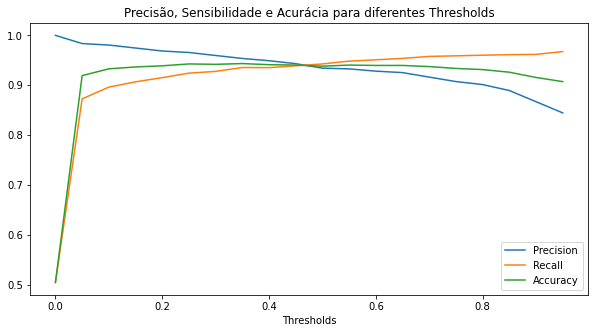

In [25]:
precisions, recalls, accuracy = precision_recall_accuracy_curve(predict, y)
plot_precision_recall_accuracy_curve(precisions, recalls, accuracy)

In [34]:
best_metrics(threshold = 0.55, predict = predict, y = y)

Matriz de Confusão:
 [[623  45]
 [ 34 624]]
Acurácia: 0.9404223227752639
Precisão 0.9327354260089686
Sensibilidade: 0.9483282674772037
F1_Score: 0.9404672192916353


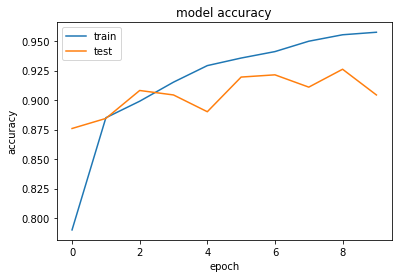

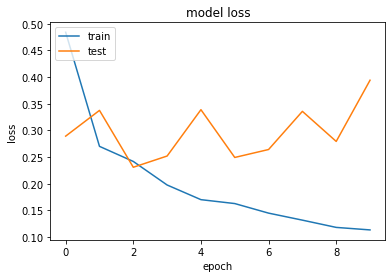

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-accuracy')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-loss')

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________